<a href="https://colab.research.google.com/github/abhikbhattacharjee/Bayesian_Modelling_Dissertation/blob/main/Physiological_Signals/Bayesian_Modelling_EDA_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-Requisites and Imports

In [ ]:
!pip install deepbayes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 1.5 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
import deepbayes
import deepbayes.optimizers as optimizers
import numpy as np
from deepbayes import PosteriorModel
import seaborn as sns
import pickle
import os
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

from matplotlib import font_manager
font_path = '/content/NewCM10-Regular.otf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

## Important Functions

In [ ]:
def get_subjective_labels(userID,task,difficulty):
    #task order: stroop, subtraction, reading
    #difficulty order: easy, hard
    subjective_ranking = [
                          [[1,4],[2,5],[2,4]],
                          [],
                          [[1,2],[1,3],[2,4]],
                          [[1,4],[1,5],[1,3]],
                          [[1,2],[3,5],[3,3]],
                          [[1,4],[1,4],[2,5]],
                          [],
                          [[2,3],[1,3],[1,1]],
                          [[1,2],[1,4],[3,4]],
                          [[2,5],[1,3],[2,5]],
                          [[1,1],[1,4],[2,3]],
                          [[4,1],[1,5],[2,5]],
                          [[1,5],[1,4],[3,3]],
                          [[2,4],[1,4],[2,5]],
                          [[2,4],[1,4],[2,3]],
                          [[1,4],[1,3],[2,3]]
                          ]
    if task == 'stroop':
        task_idx = 0
    elif task == 'subtraction':
        task_idx = 1
    elif task == 'reading':
        task_idx = 2

    if difficulty == 'easy':
        difficulty_idx = 0
    elif difficulty == 'hard':
        difficulty_idx = 1

    return  subjective_ranking[int(userID)-1][task_idx][difficulty_idx]

In [ ]:
def load_data_features(users,signals,tasks,dataDir = '/content/drive/MyDrive/Dissertation/nokia_data/',
                       labels = 'objective',subj_thre = 3,win_size = 300, overlap = False):
    xs = []
    ys = []
    for uID in users:
        for t in tasks:
            # print("Tasks: ", t)
            for s in signals:
                # print("Signal: ", s)
                hard_feat_template = dataDir + uID + '/' + t + '_0/features/'
                easy_feat_template = dataDir + uID + '/' + t + '_1/features/'
                # print("Hard Feat Template: ", hard_feat_template)
                # print("Easy Feat Template: ", easy_feat_template)
                if not np.isnan(overlap):
                    if overlap:
                        hard_feat_template  = hard_feat_template + 'overlap_'
                        easy_feat_template  = easy_feat_template + 'overlap_'
                if not np.isnan(win_size):
                    easy_feat_template = easy_feat_template + str(win_size) + '/' + s
                    hard_feat_template = hard_feat_template + str(win_size) + '/' + s
                else:
                    hard_feat_template = dataDir + uID + '/' + t + '_0/features/' + s
                    easy_feat_template = dataDir + uID + '/' + t + '_1/features/' + s

                if not np.isnan(win_size):
                    count = 0
                else:
                    count = ''

                while True:
                    hard_feat_file = hard_feat_template + str(count) + '.csv'
                    # print("Hard Feat File: ", hard_feat_file)
                    # print(os.path.exists(hard_feat_file))
                    if os.path.exists(hard_feat_file):
                        xs.append(  np.loadtxt(  hard_feat_file , delimiter = ','       )   )
                        # print("xsh: ", ys)
                        if labels == 'objective':
                            ys.append(1)
                            # print("ys1h: ", ys)
                        elif labels == 'subjective':
                            y_curr = get_subjective_labels(uID,t,'hard')
                            ys.append(y_curr)
                            # print("ys2h: ", ys)
                    else:
                        break
                    if not np.isnan(win_size):
                        count = count + 1
                    else:
                        break

                if not np.isnan(win_size):
                    count = 0
                else:
                    count = ''

                while True:
                    easy_feat_file = easy_feat_template + str(count) + '.csv'
                    # print("Easy Feat File: ", easy_feat_file)
                    # print(os.path.exists(hard_feat_file))
                    if os.path.exists(easy_feat_file):
                        xs.append(  np.loadtxt(  easy_feat_file , delimiter = ','       )   )
                        # print("xse: ", xs)
                        if labels == 'objective':
                            ys.append(0)
                            # print("ys1e: ", ys)
                        elif labels == 'subjective':
                            y_curr = get_subjective_labels(uID,t,'easy')
                            ys.append(y_curr)
                            # print("ys2e: ", ys)
                    else:
                        break
                    if not np.isnan(win_size):
                        count = count + 1
                    else:
                        break
                    count = count + 1
    ys = np.asarray(ys)
    if labels == 'subjective':
        pos_idxs = (ys > subj_thre)
        neg_idxs = (ys <= subj_thre)
        ys[pos_idxs] = 1
        ys[neg_idxs] = 0
    return np.asarray(xs), ys

In [ ]:
def my_predict(model, input, n=35):
    if(model.det):
        return model.model(input)
    out = []
    for i in range(n):
        model.model.set_weights(model.sample())
        out.append(model.model(input).numpy())
    return np.mean(out,axis=0), np.var(out,axis=0)

In [ ]:
def augment_data(data, num_augmented_samples):
    num_samples, num_features = data.shape
    augmented_data = np.zeros((num_augmented_samples, num_features))
    for i in range(num_features):
      mean = np.mean(data[:, i])
      std = np.std(data[:, i])
      noise = np.random.normal(loc=mean, scale=std, size=num_augmented_samples)
      augmented_data[:, i] = data[np.random.choice(num_samples, num_augmented_samples), i] + noise
    return augmented_data

In [ ]:
def time_shift_data(data, max_shift):
    augmented_data = []
    time_shifts = np.arange(-max_shift, max_shift + 1)
    for shift in time_shifts:
        shifted_data = np.roll(data, shift, axis=1)
        augmented_data.append(shifted_data)

    augmented_data = np.array(augmented_data)

    return augmented_data

## Load Train and Test Data

In [ ]:
signals = ['eda']
userIDs = ['1','3','4','5','6','8','9','10','11','12','13','14','15','16']
labels = 'objective'
tasks = ['stroop', 'subtraction', 'reading']

In [ ]:
train_users, val_users = train_test_split(userIDs, test_size=0.25, random_state=42)
print("Train Users: ", train_users)
print("Test Users: ", val_users)
X_train, y_train = load_data_features(train_users,signals,tasks,labels=labels,subj_thre = 3, win_size = np.nan,overlap = np.nan)
X_test, y_test = load_data_features(val_users,signals,tasks,labels=labels, subj_thre = 3, win_size = np.nan,overlap = np.nan)

print("Y Train: ", y_train)
print("Y Test: ", y_test)

Train Users:  ['8', '11', '4', '3', '16', '6', '10', '13', '5', '9']
Test Users:  ['12', '14', '1', '15']
Y Train:  [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
Y Test:  [1 0 1 0 1 0]


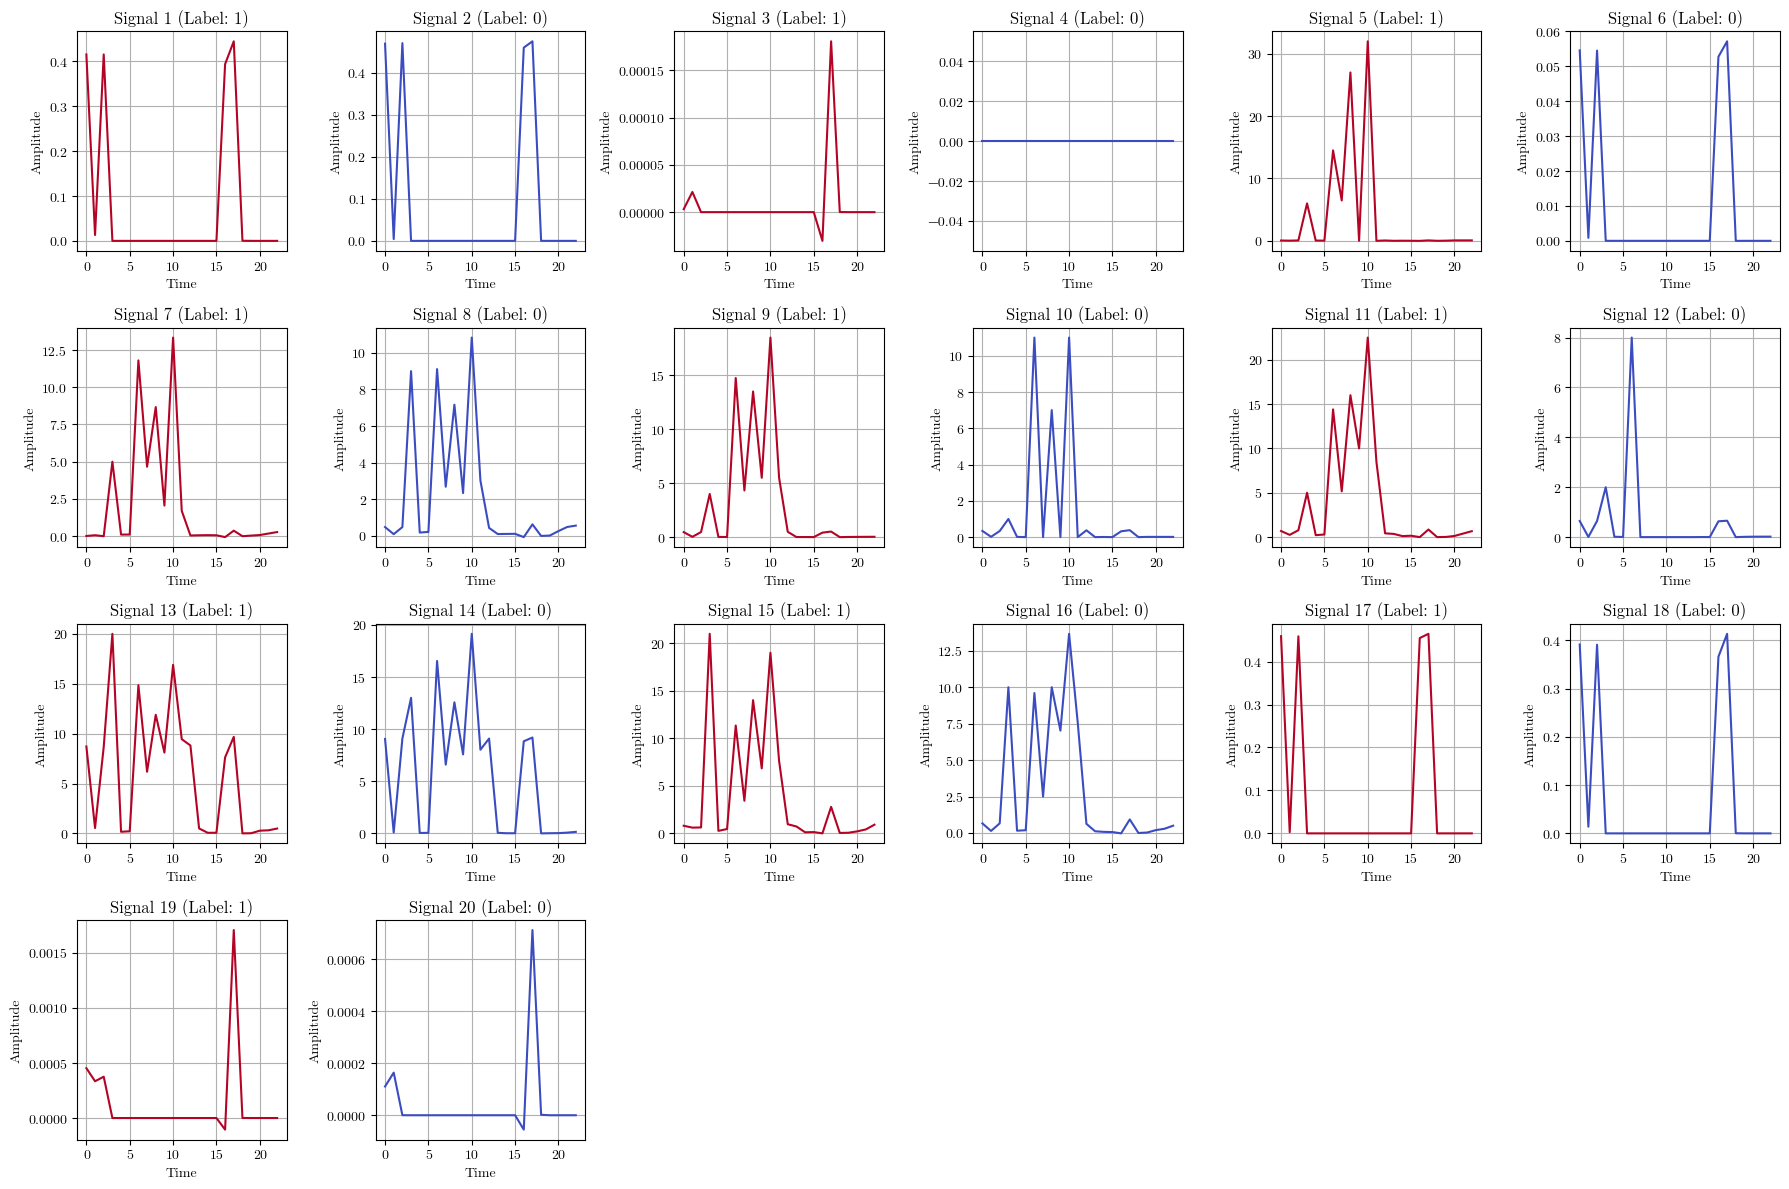

In [ ]:
num_signals, signal_length = X_train.shape

time_points = np.arange(signal_length)

num_rows = 4
num_cols = 6
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))

axes = axes.flatten()
cmap = plt.get_cmap('coolwarm', len(np.unique(y_train)))
for i in range(num_signals):
    label = y_train[i]
    color = cmap(label)
    axes[i].plot(time_points, X_train[i], label = f'Signal {i+1}', color = color)
    axes[i].set_title(f'Signal {i+1} (Label: {label})')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

for i in range(num_signals, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Generating Synthetic Data

In [ ]:
# random_sample = augment_data(X_train, 24)
max_shift = 3
xTrain1 = time_shift_data(X_train, max_shift)
random_sample = xTrain1[1]

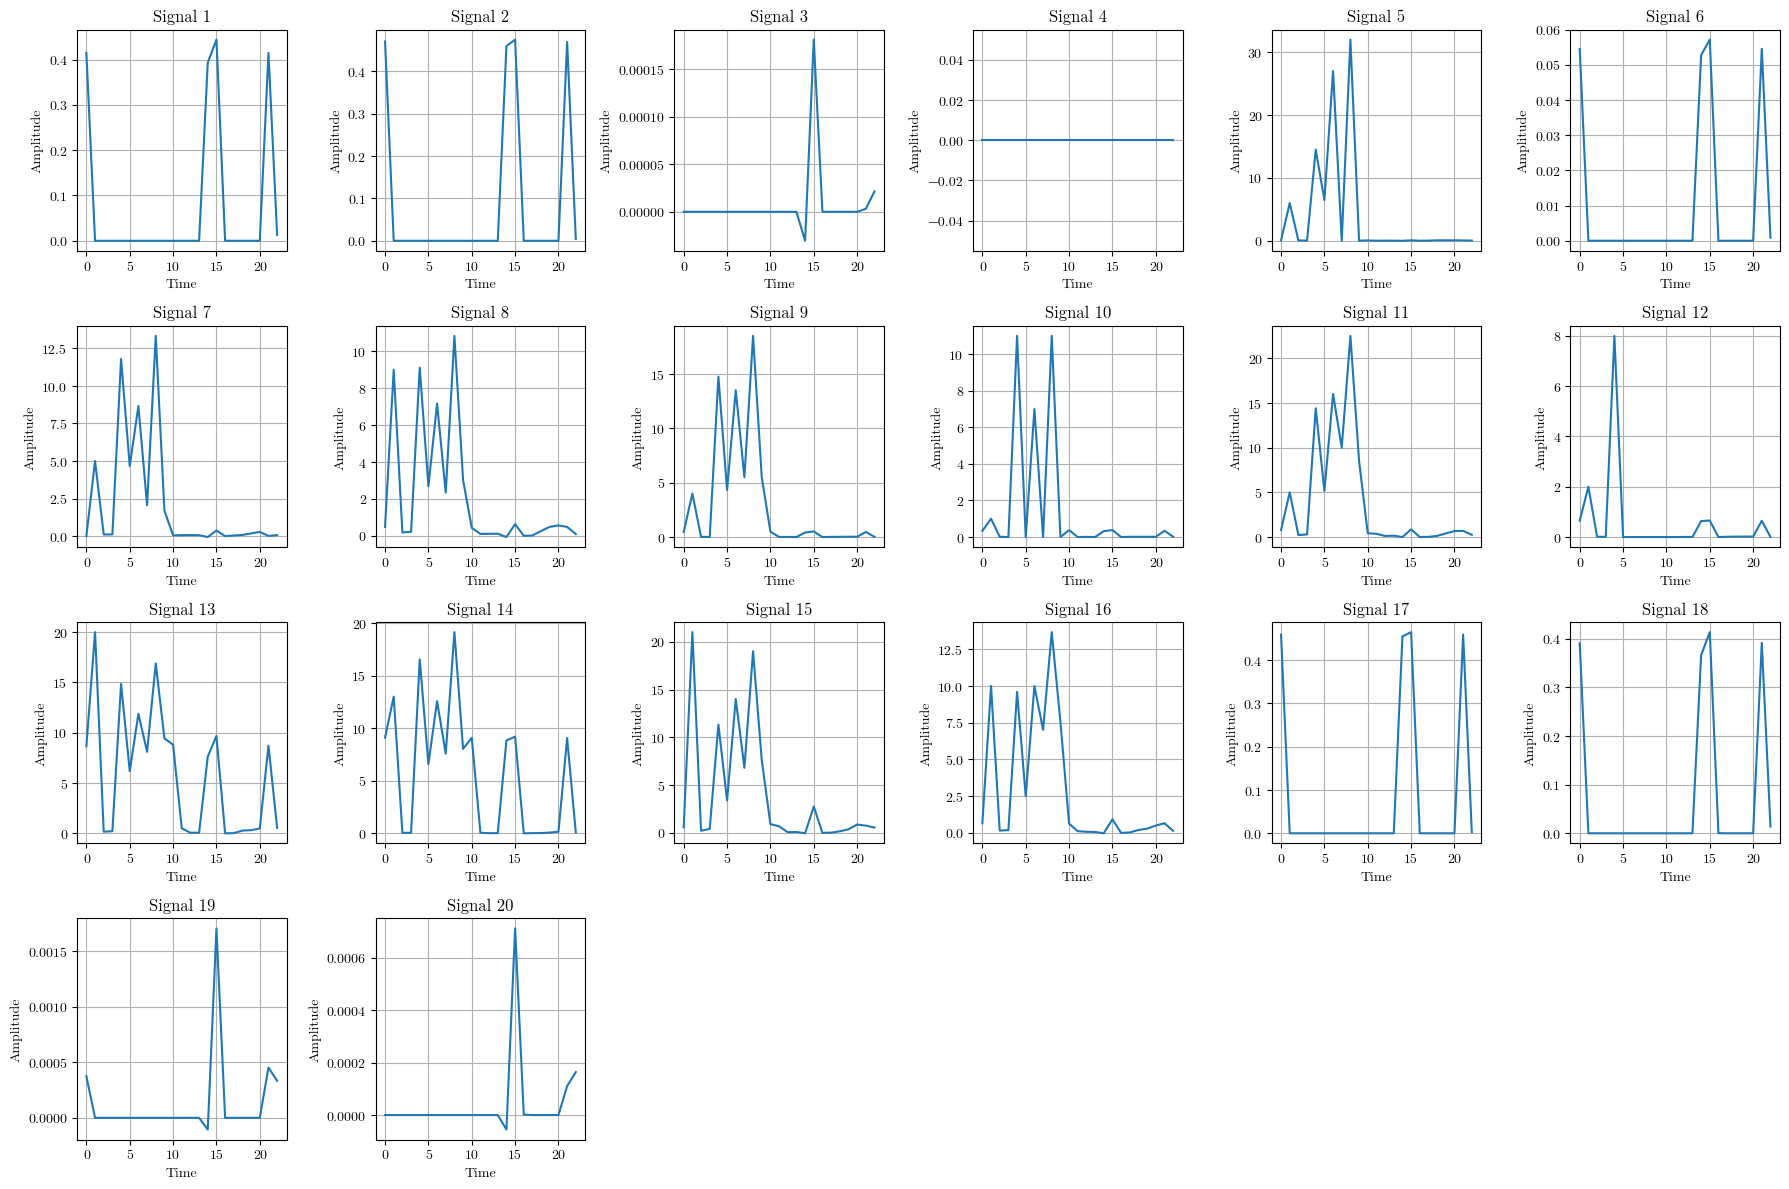

In [ ]:
num_signals, signal_length = random_sample.shape

time_points = np.arange(signal_length)

fig, axes = plt.subplots(4, 6, figsize=(18, 12))

axes = axes.flatten()

for i in range(num_signals):
    axes[i].plot(time_points, random_sample[i, :], label=f'Signal {i+1}')
    axes[i].set_title(f'Signal {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

for i in range(num_signals, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Load Simpler Random Forest Prior (Catalytic)

In [ ]:
file_path = '/content/drive/MyDrive/Dissertation/modelPrior.p'

with open(file_path, 'rb') as file:
  rfModel = pickle.load(file)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
rfModel

RandomForestClassifier(max_depth=3, n_estimators=25)

In [ ]:
testPred = rfModel.predict(random_sample)

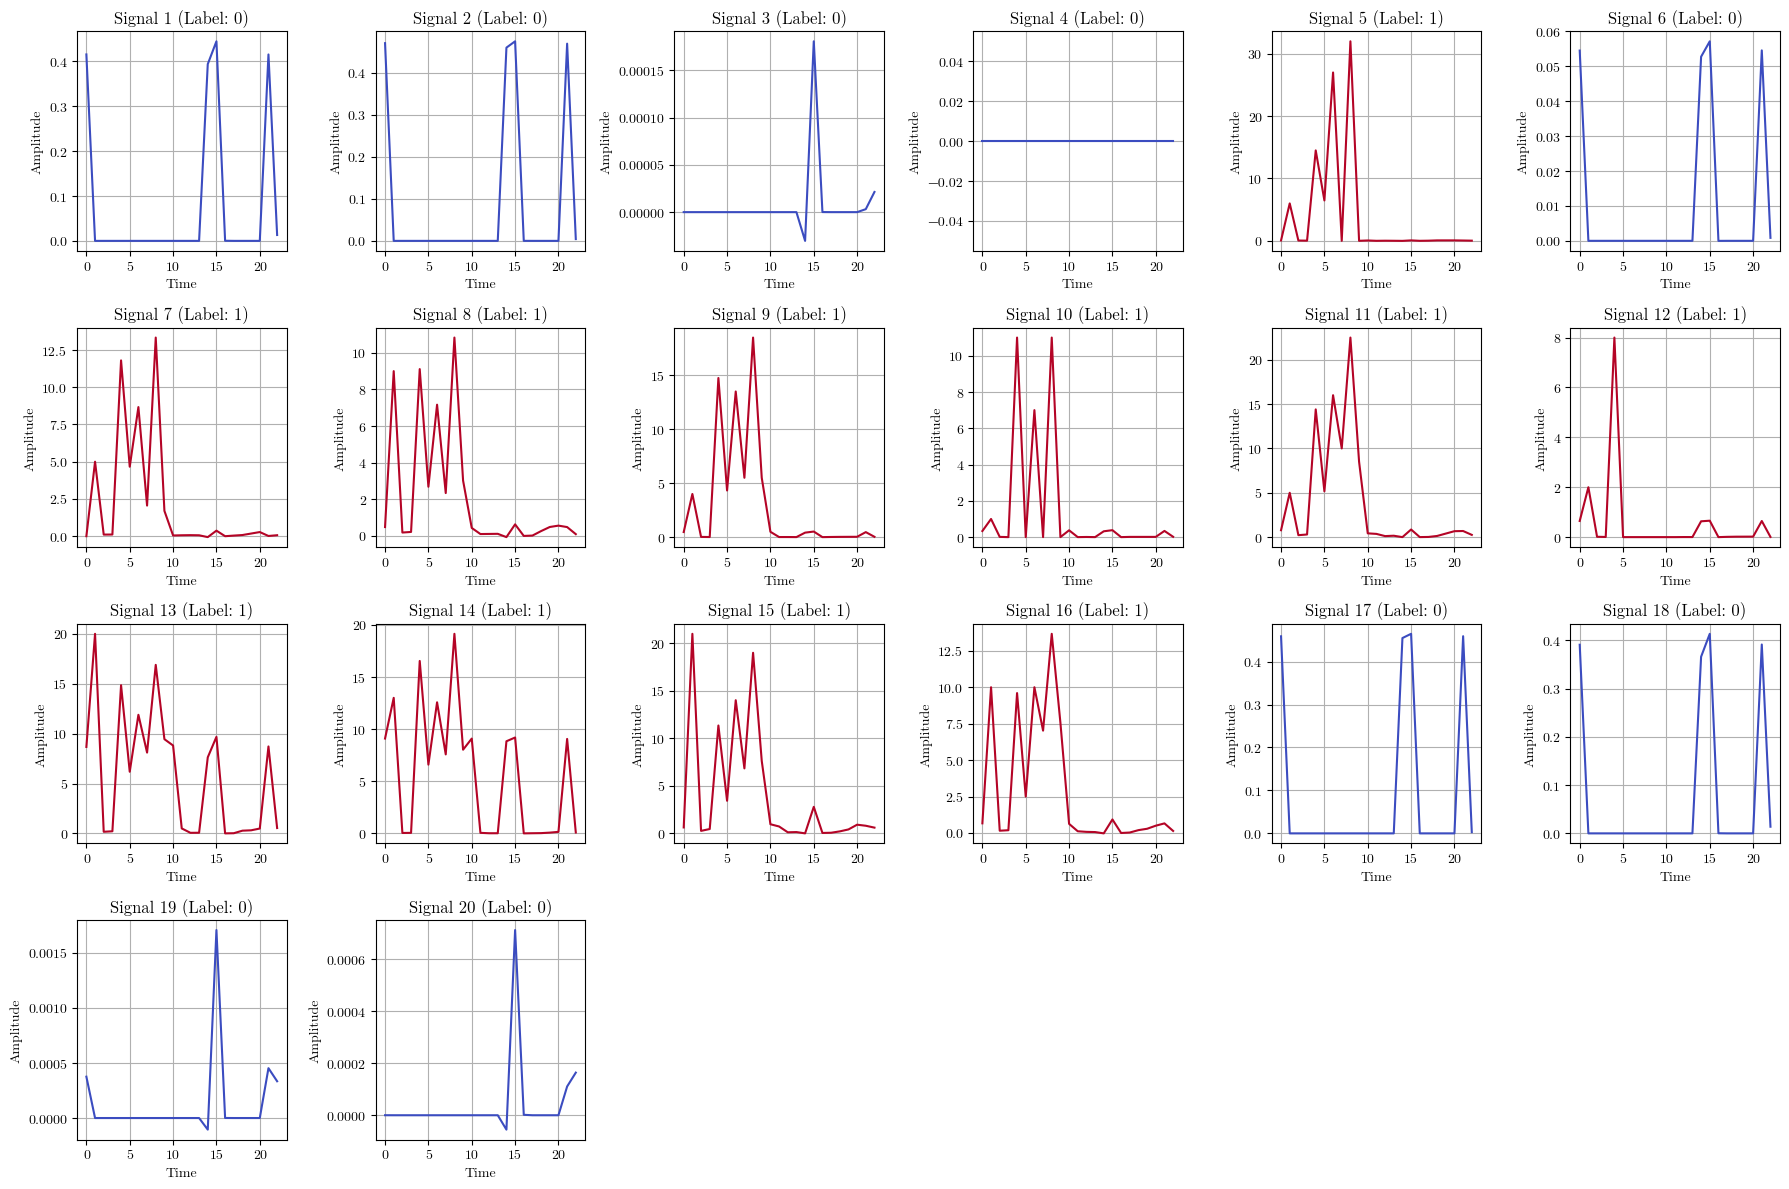

In [ ]:
num_signals, signal_length = random_sample.shape

time_points = np.arange(signal_length)

num_rows = 4
num_cols = 6
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))

axes = axes.flatten()
cmap = plt.get_cmap('coolwarm', len(np.unique(testPred)))
for i in range(num_signals):
    label = testPred[i]
    color = cmap(label)
    axes[i].plot(time_points, random_sample[i], label = f'Signal {i+1}', color = color)
    axes[i].set_title(f'Signal {i+1} (Label: {label})')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

for i in range(num_signals, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ros = RandomOverSampler(random_state=0)
# random_sample, testPred = ros.fit_resample(random_sample, testPred)


## Training the BNN with Catalytic Prior

In [ ]:
model_new = Sequential()
model_new.add(Dense(10, activation='relu', input_shape=(23,)))
model_new.add(Dense(2, activation='softmax'))

loss = tf.keras.losses.SparseCategoricalCrossentropy()
opt = optimizers.BayesByBackprop()
learning_rate = 0.005

bayes_model_rf_prior = opt.compile(model_new, loss_fn = loss, epochs = 100, learning_rate = learning_rate, kl_weight = 10, batch_size = 124)

This optimizer does not have a default compilation method. Please make sure to call the correct .compile method before use.
BayesKeras: Using implicit prior
(23, 10) 0.20851441405707477
(10, 2) 0.31622776601683794
BayesKeras: Using implicit prior
(23, 10) 0.20851441405707477
(10, 2) 0.31622776601683794
deepbayes: Using passed loss_fn as the data likelihood in the KL loss


In [ ]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(random_sample, testPred, test_size = 0.25, random_state=0)
y_train_new = y_train_new.astype("int64").reshape(-1,1)
y_test_new = y_test_new.astype("int64").reshape(-1,1)

In [ ]:
bayes_model_rf_prior.train(X_train_new, y_train_new, X_test_new, y_test_new)

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch 1, loss: 30.261, acc: 0.400, val_loss: 1.514, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 2, loss: 27.573, acc: 0.667, val_loss: 0.397, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


Epoch 3, loss: 31.492, acc: 0.533, val_loss: 0.515, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch 4, loss: 30.214, acc: 0.533, val_loss: 1.663, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch 5, loss: 28.101, acc: 0.667, val_loss: 0.365, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 6, loss: 32.164, acc: 0.600, val_loss: 0.628, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


Epoch 7, loss: -9.200, acc: 0.600, val_loss: 0.928, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 8, loss: 27.527, acc: 0.600, val_loss: 0.798, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Epoch 9, loss: 33.554, acc: 0.400, val_loss: 2.832, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 10, loss: 31.860, acc: 0.333, val_loss: 0.565, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


Epoch 11, loss: 18.034, acc: 0.600, val_loss: 0.708, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


Epoch 12, loss: 22.557, acc: 0.400, val_loss: 0.575, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


Epoch 13, loss: 24.647, acc: 0.600, val_loss: 0.795, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epoch 14, loss: 21.851, acc: 1.000, val_loss: 0.338, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Epoch 15, loss: 31.267, acc: 1.000, val_loss: 0.332, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


Epoch 16, loss: 22.152, acc: 0.733, val_loss: 0.400, val_acc: 0.800


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 17, loss: 26.487, acc: 0.400, val_loss: 2.266, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 18, loss: 32.578, acc: 0.933, val_loss: 0.632, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Epoch 19, loss: 32.319, acc: 0.133, val_loss: 0.923, val_acc: 0.000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Epoch 20, loss: 26.784, acc: 0.533, val_loss: 1.831, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 21, loss: 25.199, acc: 0.800, val_loss: 0.385, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Epoch 22, loss: 23.851, acc: 0.400, val_loss: 1.718, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Epoch 23, loss: 33.535, acc: 0.333, val_loss: 1.431, val_acc: 0.000


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


Epoch 24, loss: 26.703, acc: 0.800, val_loss: 0.398, val_acc: 0.800


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 25, loss: 29.785, acc: 0.400, val_loss: 3.384, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Epoch 26, loss: 12.010, acc: 0.600, val_loss: 0.825, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


Epoch 27, loss: 29.587, acc: 0.933, val_loss: 0.326, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Epoch 28, loss: 29.532, acc: 0.533, val_loss: 0.477, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch 29, loss: 24.613, acc: 0.600, val_loss: 0.543, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


Epoch 30, loss: 24.329, acc: 0.467, val_loss: 2.245, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Epoch 31, loss: 24.372, acc: 0.467, val_loss: 0.429, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 32, loss: 30.591, acc: 0.600, val_loss: 0.788, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


Epoch 33, loss: 26.621, acc: 0.467, val_loss: 0.555, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 34, loss: 27.285, acc: 0.600, val_loss: 0.749, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch 35, loss: 28.957, acc: 0.600, val_loss: 0.757, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Epoch 36, loss: 14.708, acc: 0.533, val_loss: 1.290, val_acc: 0.200


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Epoch 37, loss: 29.691, acc: 0.800, val_loss: 0.807, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


Epoch 38, loss: 25.091, acc: 0.533, val_loss: 0.582, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 39, loss: 18.194, acc: 0.600, val_loss: 1.242, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


Epoch 40, loss: 12.648, acc: 0.733, val_loss: 0.277, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Epoch 41, loss: 20.114, acc: 0.000, val_loss: 1.238, val_acc: 0.000


100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


Epoch 42, loss: 25.143, acc: 0.533, val_loss: 0.472, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epoch 43, loss: 26.339, acc: 0.600, val_loss: 0.614, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


Epoch 44, loss: 24.872, acc: 1.000, val_loss: 0.232, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


Epoch 45, loss: 28.398, acc: 0.667, val_loss: 0.595, val_acc: 0.800


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Epoch 46, loss: 29.089, acc: 0.800, val_loss: 0.437, val_acc: 0.800


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


Epoch 47, loss: 24.567, acc: 1.000, val_loss: 0.346, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Epoch 48, loss: 21.747, acc: 0.867, val_loss: 0.198, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch 49, loss: 24.325, acc: 0.600, val_loss: 0.723, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch 50, loss: 25.826, acc: 0.600, val_loss: 0.472, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


Epoch 51, loss: 25.731, acc: 0.800, val_loss: 0.238, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


Epoch 52, loss: 26.033, acc: 0.800, val_loss: 0.420, val_acc: 0.800


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch 53, loss: 24.377, acc: 0.000, val_loss: 4.428, val_acc: 0.000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 54, loss: 22.794, acc: 0.600, val_loss: 0.504, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


Epoch 55, loss: 24.680, acc: 0.333, val_loss: 0.709, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Epoch 56, loss: 22.941, acc: 0.933, val_loss: 0.287, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch 57, loss: 17.771, acc: 0.533, val_loss: 0.835, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch 58, loss: 21.114, acc: 0.600, val_loss: 0.879, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


Epoch 59, loss: 23.208, acc: 0.600, val_loss: 1.298, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch 60, loss: 17.811, acc: 0.400, val_loss: 2.597, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


Epoch 61, loss: 26.695, acc: 1.000, val_loss: 0.297, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch 62, loss: 18.699, acc: 0.600, val_loss: 1.073, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


Epoch 63, loss: 23.344, acc: 0.600, val_loss: 0.604, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch 64, loss: 25.495, acc: 0.600, val_loss: 0.576, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 65, loss: 24.933, acc: 0.667, val_loss: 0.196, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch 66, loss: 24.717, acc: 0.600, val_loss: 0.561, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch 67, loss: 14.418, acc: 0.800, val_loss: 0.195, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch 68, loss: 24.667, acc: 0.533, val_loss: 3.277, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


Epoch 69, loss: 19.768, acc: 0.800, val_loss: 0.294, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


Epoch 70, loss: 20.996, acc: 0.600, val_loss: 1.071, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


Epoch 71, loss: 25.549, acc: 0.600, val_loss: 0.627, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


Epoch 72, loss: 21.778, acc: 0.933, val_loss: 0.304, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Epoch 73, loss: 23.971, acc: 0.600, val_loss: 0.563, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


Epoch 74, loss: 16.370, acc: 0.933, val_loss: 0.180, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch 75, loss: 22.944, acc: 0.800, val_loss: 0.412, val_acc: 0.800


100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


Epoch 76, loss: 21.946, acc: 0.600, val_loss: 0.592, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


Epoch 77, loss: 20.146, acc: 0.733, val_loss: 0.284, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 78, loss: 25.842, acc: 0.400, val_loss: 3.764, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Epoch 79, loss: 24.742, acc: 0.533, val_loss: 1.111, val_acc: 0.200


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


Epoch 80, loss: 24.400, acc: 0.600, val_loss: 0.491, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


Epoch 81, loss: 28.518, acc: 0.067, val_loss: 7.421, val_acc: 0.000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 82, loss: 21.774, acc: 0.600, val_loss: 0.630, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


Epoch 83, loss: 17.230, acc: 0.533, val_loss: 1.742, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


Epoch 84, loss: 20.468, acc: 0.600, val_loss: 0.618, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Epoch 85, loss: 17.205, acc: 0.600, val_loss: 0.859, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Epoch 86, loss: 21.502, acc: 0.600, val_loss: 1.187, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


Epoch 87, loss: 19.272, acc: 1.000, val_loss: 0.184, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


Epoch 88, loss: 20.261, acc: 0.600, val_loss: 0.556, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Epoch 89, loss: 21.503, acc: 0.533, val_loss: 0.513, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 90, loss: 26.267, acc: 0.067, val_loss: 2.972, val_acc: 0.000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


Epoch 91, loss: 24.571, acc: 0.600, val_loss: 0.692, val_acc: 0.400


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


Epoch 92, loss: 19.397, acc: 0.600, val_loss: 2.057, val_acc: 0.200


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


Epoch 93, loss: 23.805, acc: 0.667, val_loss: 0.601, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 94, loss: 21.434, acc: 0.867, val_loss: 0.355, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch 95, loss: 17.685, acc: 1.000, val_loss: 0.206, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


Epoch 96, loss: 19.233, acc: 1.000, val_loss: 0.302, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


Epoch 97, loss: 20.421, acc: 0.733, val_loss: 0.241, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Epoch 98, loss: 18.996, acc: 0.400, val_loss: 2.471, val_acc: 0.600


100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


Epoch 99, loss: 17.466, acc: 1.000, val_loss: 0.201, val_acc: 1.000


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

Epoch 100, loss: 21.929, acc: 0.600, val_loss: 1.211, val_acc: 0.400


In [ ]:
prediction_mean,prediction_variance = my_predict(bayes_model_rf_prior,X_train_new)
print("Prediction Mean: ", prediction_mean)
print("Prediction Variance: ", prediction_variance)

Prediction Mean:  [[0.38674912 0.6132508 ]
 [0.22490011 0.7750999 ]
 [0.19953655 0.80046344]
 [0.26972702 0.73027277]
 [0.3942914  0.6057086 ]
 [0.39397135 0.6060286 ]
 [0.17019133 0.8298088 ]
 [0.26320776 0.7367923 ]
 [0.19457254 0.8054275 ]
 [0.3847464  0.61525375]
 [0.26808295 0.731917  ]
 [0.39429107 0.6057089 ]
 [0.38605863 0.6139415 ]
 [0.20019647 0.7998037 ]
 [0.17740151 0.82259846]]
Prediction Variance:  [[0.02852224 0.02852224]
 [0.11254093 0.11254094]
 [0.12668158 0.12668157]
 [0.16651948 0.16651952]
 [0.028713   0.02871299]
 [0.02858593 0.02858594]
 [0.09696563 0.09696563]
 [0.12807286 0.12807286]
 [0.08990218 0.08990218]
 [0.02876148 0.02876149]
 [0.07595057 0.07595059]
 [0.02871244 0.02871244]
 [0.02864258 0.02864258]
 [0.10788015 0.10788015]
 [0.11413541 0.11413541]]


In [ ]:
bayes_model_rf_prior.save("PosteriorModels/model")
del bayes_model_rf_prior

/usr/local/lib/python3.10/dist-packages/deepbayes/optimizers/bayesbybackprop.py:190: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(path+"/mean", np.asarray(self.posterior_mean))
/usr/local/lib/python3.10/dist-packages/deepbayes/optimizers/bayesbybackprop.py:191: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(path+"/var", np.asarray(var))


## Training on actual EDA Signals

In [ ]:
retrain_model = PosteriorModel("PosteriorModels/model")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                240       
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________
BayesKeras detected the above model 
 None


In [ ]:
y_train = y_train.astype("int64").reshape(-1,1)
y_test = y_test.astype("int64").reshape(-1,1)

In [ ]:
bayes_model = opt.compile(model_new, loss_fn=loss, learning_rate = 0.005, epochs=150, batch_size = 124)
bayes_model.posterior_mean = retrain_model.posterior_mean.tolist()
bayes_model.posterior_var = retrain_model.posterior_var.tolist()

BayesKeras: Using implicit prior
(23, 10) 0.20851441405707477
(10, 2) 0.31622776601683794
BayesKeras: Using implicit prior
(23, 10) 0.20851441405707477
(10, 2) 0.31622776601683794
deepbayes: Using passed loss_fn as the data likelihood in the KL loss


In [ ]:
bayes_model.train(X_train, y_train, X_test, y_test)

100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


Epoch 1, loss: 7.615, acc: 0.650, val_loss: 9.520, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


Epoch 2, loss: 8.767, acc: 0.500, val_loss: 8.083, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


Epoch 3, loss: 3.906, acc: 0.600, val_loss: 1.970, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


Epoch 4, loss: 21.915, acc: 0.450, val_loss: 7.517, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


Epoch 5, loss: 12.819, acc: 0.500, val_loss: 8.739, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


Epoch 6, loss: 4.170, acc: 0.450, val_loss: 0.463, val_acc: 0.667


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


Epoch 7, loss: 4.568, acc: 0.500, val_loss: 5.920, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


Epoch 8, loss: 3.787, acc: 0.550, val_loss: 4.147, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch 9, loss: 2.090, acc: 0.450, val_loss: 0.823, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch 10, loss: 11.855, acc: 0.500, val_loss: 4.769, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


Epoch 11, loss: 8.790, acc: 0.450, val_loss: 0.790, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 12, loss: 17.032, acc: 0.500, val_loss: 22.085, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


Epoch 13, loss: 21.351, acc: 0.500, val_loss: 19.948, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Epoch 14, loss: 11.808, acc: 0.500, val_loss: 1.132, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


Epoch 15, loss: 21.515, acc: 0.500, val_loss: 18.689, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


Epoch 16, loss: 13.073, acc: 0.500, val_loss: 12.581, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


Epoch 17, loss: 2.878, acc: 0.600, val_loss: 2.209, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Epoch 18, loss: 3.417, acc: 0.550, val_loss: 1.144, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 19, loss: 21.871, acc: 0.600, val_loss: 8.172, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


Epoch 20, loss: 16.022, acc: 0.450, val_loss: 9.140, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


Epoch 21, loss: 3.203, acc: 0.550, val_loss: 1.619, val_acc: 0.333


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Epoch 22, loss: 7.439, acc: 0.600, val_loss: 10.558, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch 23, loss: 6.715, acc: 0.500, val_loss: 6.263, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


Epoch 24, loss: 7.246, acc: 0.450, val_loss: 5.684, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Epoch 25, loss: 8.736, acc: 0.500, val_loss: 7.899, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch 26, loss: 20.233, acc: 0.400, val_loss: 11.299, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


Epoch 27, loss: 21.002, acc: 0.500, val_loss: 15.668, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Epoch 28, loss: 10.284, acc: 0.500, val_loss: 7.840, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch 29, loss: 4.066, acc: 0.500, val_loss: 3.696, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


Epoch 30, loss: 14.306, acc: 0.350, val_loss: 0.462, val_acc: 0.667


100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


Epoch 31, loss: 9.038, acc: 0.500, val_loss: 5.667, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


Epoch 32, loss: 8.754, acc: 0.550, val_loss: 10.356, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch 33, loss: 24.211, acc: 0.550, val_loss: 20.581, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Epoch 34, loss: 11.280, acc: 0.500, val_loss: 10.689, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Epoch 35, loss: 5.670, acc: 0.600, val_loss: 5.832, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Epoch 36, loss: 20.420, acc: 0.500, val_loss: 19.621, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


Epoch 37, loss: 9.821, acc: 0.450, val_loss: 7.715, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


Epoch 38, loss: 14.746, acc: 0.500, val_loss: 7.704, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


Epoch 39, loss: 21.619, acc: 0.500, val_loss: 20.893, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


Epoch 40, loss: 4.420, acc: 0.350, val_loss: 3.596, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 41, loss: 31.565, acc: 0.500, val_loss: 25.286, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Epoch 42, loss: 7.700, acc: 0.550, val_loss: 5.195, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch 43, loss: 5.482, acc: 0.600, val_loss: 3.775, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Epoch 44, loss: 5.569, acc: 0.500, val_loss: 3.010, val_acc: 0.333


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Epoch 45, loss: 5.485, acc: 0.500, val_loss: 2.717, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch 46, loss: 28.041, acc: 0.500, val_loss: 23.881, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


Epoch 47, loss: 9.835, acc: 0.550, val_loss: 0.485, val_acc: 0.667


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Epoch 48, loss: 1.497, acc: 0.600, val_loss: 0.870, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Epoch 49, loss: 1.647, acc: 0.600, val_loss: 1.337, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Epoch 50, loss: 9.072, acc: 0.500, val_loss: 8.567, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


Epoch 51, loss: 11.698, acc: 0.500, val_loss: 9.814, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


Epoch 52, loss: 9.181, acc: 0.400, val_loss: 4.618, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


Epoch 53, loss: 13.354, acc: 0.350, val_loss: 3.760, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


Epoch 54, loss: 6.933, acc: 0.500, val_loss: 5.474, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Epoch 55, loss: 3.691, acc: 0.500, val_loss: 3.293, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 56, loss: 1.851, acc: 0.500, val_loss: 1.874, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


Epoch 57, loss: 13.720, acc: 0.500, val_loss: 10.393, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Epoch 58, loss: 3.236, acc: 0.600, val_loss: 3.094, val_acc: 0.333


100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


Epoch 59, loss: 10.980, acc: 0.500, val_loss: 7.818, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch 60, loss: 14.888, acc: 0.600, val_loss: 16.917, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.92it/s]


Epoch 61, loss: 3.097, acc: 0.500, val_loss: 1.166, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


Epoch 62, loss: 3.754, acc: 0.400, val_loss: 0.699, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Epoch 63, loss: 18.733, acc: 0.500, val_loss: 5.529, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 64, loss: 10.431, acc: 0.500, val_loss: 4.408, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


Epoch 65, loss: 17.190, acc: 0.450, val_loss: 1.151, val_acc: 0.667


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


Epoch 66, loss: 13.919, acc: 0.500, val_loss: 10.524, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


Epoch 67, loss: 15.317, acc: 0.500, val_loss: 6.339, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


Epoch 68, loss: 5.148, acc: 0.350, val_loss: 3.448, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Epoch 69, loss: 3.026, acc: 0.600, val_loss: 3.249, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


Epoch 70, loss: 8.964, acc: 0.500, val_loss: 1.859, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


Epoch 71, loss: 6.292, acc: 0.350, val_loss: 1.765, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 72, loss: 10.321, acc: 0.450, val_loss: 2.698, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


Epoch 73, loss: 3.514, acc: 0.600, val_loss: 2.764, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch 74, loss: 8.109, acc: 0.550, val_loss: 5.572, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch 75, loss: 18.857, acc: 0.550, val_loss: 15.224, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 76, loss: 2.682, acc: 0.500, val_loss: 1.021, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


Epoch 77, loss: 3.065, acc: 0.500, val_loss: 4.826, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


Epoch 78, loss: 3.542, acc: 0.500, val_loss: 3.838, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


Epoch 79, loss: 6.829, acc: 0.550, val_loss: 5.880, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch 80, loss: 4.793, acc: 0.500, val_loss: 1.859, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 81, loss: 2.015, acc: 0.400, val_loss: 1.633, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Epoch 82, loss: 5.978, acc: 0.550, val_loss: 4.194, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Epoch 83, loss: 13.962, acc: 0.400, val_loss: 7.385, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


Epoch 84, loss: 8.155, acc: 0.400, val_loss: 4.691, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


Epoch 85, loss: 1.412, acc: 0.500, val_loss: 1.653, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


Epoch 86, loss: 7.409, acc: 0.600, val_loss: 3.963, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


Epoch 87, loss: 24.612, acc: 0.500, val_loss: 19.923, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


Epoch 88, loss: 4.795, acc: 0.500, val_loss: 3.626, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


Epoch 89, loss: 15.526, acc: 0.500, val_loss: 6.676, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


Epoch 90, loss: 9.167, acc: 0.450, val_loss: 4.186, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


Epoch 91, loss: 2.849, acc: 0.550, val_loss: 0.865, val_acc: 0.333


100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


Epoch 92, loss: 3.399, acc: 0.500, val_loss: 1.113, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch 93, loss: 5.380, acc: 0.600, val_loss: 5.027, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch 94, loss: 1.835, acc: 0.500, val_loss: 1.383, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 95, loss: 26.494, acc: 0.500, val_loss: 17.099, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


Epoch 96, loss: 9.183, acc: 0.550, val_loss: 3.095, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


Epoch 97, loss: 3.315, acc: 0.550, val_loss: 1.780, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


Epoch 98, loss: 4.346, acc: 0.500, val_loss: 1.923, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch 99, loss: 4.081, acc: 0.500, val_loss: 2.903, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Epoch 100, loss: 10.930, acc: 0.500, val_loss: 13.683, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


Epoch 101, loss: 3.969, acc: 0.450, val_loss: 3.403, val_acc: 0.333


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Epoch 102, loss: 7.309, acc: 0.550, val_loss: 6.474, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


Epoch 103, loss: 2.943, acc: 0.400, val_loss: 1.793, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Epoch 104, loss: 12.860, acc: 0.500, val_loss: 6.484, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 105, loss: 4.768, acc: 0.400, val_loss: 2.512, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


Epoch 106, loss: 11.295, acc: 0.550, val_loss: 11.462, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch 107, loss: 5.446, acc: 0.500, val_loss: 3.624, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch 108, loss: 3.257, acc: 0.450, val_loss: 0.755, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


Epoch 109, loss: 4.438, acc: 0.550, val_loss: 1.515, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch 110, loss: 2.028, acc: 0.550, val_loss: 2.615, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


Epoch 111, loss: 1.900, acc: 0.500, val_loss: 1.535, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch 112, loss: 4.903, acc: 0.500, val_loss: 4.395, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


Epoch 113, loss: 3.782, acc: 0.350, val_loss: 0.914, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 114, loss: 2.610, acc: 0.550, val_loss: 2.808, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch 115, loss: 4.253, acc: 0.500, val_loss: 4.998, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Epoch 116, loss: 2.171, acc: 0.450, val_loss: 1.581, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


Epoch 117, loss: 28.212, acc: 0.500, val_loss: 22.836, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Epoch 118, loss: 6.214, acc: 0.450, val_loss: 2.596, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch 119, loss: 17.099, acc: 0.550, val_loss: 14.955, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Epoch 120, loss: 2.775, acc: 0.450, val_loss: 2.281, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Epoch 121, loss: 8.633, acc: 0.400, val_loss: 1.535, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Epoch 122, loss: 1.152, acc: 0.500, val_loss: 1.237, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch 123, loss: 2.144, acc: 0.600, val_loss: 2.896, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


Epoch 124, loss: 3.031, acc: 0.650, val_loss: 2.021, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Epoch 125, loss: 5.571, acc: 0.550, val_loss: 5.039, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


Epoch 126, loss: 0.845, acc: 0.500, val_loss: 0.723, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


Epoch 127, loss: 0.863, acc: 0.550, val_loss: 0.943, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


Epoch 128, loss: 4.859, acc: 0.350, val_loss: 2.671, val_acc: 0.667


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Epoch 129, loss: 1.141, acc: 0.550, val_loss: 1.248, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


Epoch 130, loss: 14.838, acc: 0.550, val_loss: 13.547, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Epoch 131, loss: 4.349, acc: 0.450, val_loss: 1.027, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


Epoch 132, loss: 10.537, acc: 0.450, val_loss: 4.026, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch 133, loss: 15.894, acc: 0.450, val_loss: 6.063, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


Epoch 134, loss: 8.841, acc: 0.550, val_loss: 8.496, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


Epoch 135, loss: 1.910, acc: 0.550, val_loss: 1.772, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Epoch 136, loss: 4.602, acc: 0.550, val_loss: 7.096, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Epoch 137, loss: 2.829, acc: 0.500, val_loss: 4.055, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch 138, loss: 2.216, acc: 0.600, val_loss: 1.696, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


Epoch 139, loss: 3.493, acc: 0.400, val_loss: 1.922, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch 140, loss: 0.882, acc: 0.450, val_loss: 0.780, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


Epoch 141, loss: 2.047, acc: 0.650, val_loss: 1.841, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch 142, loss: 7.924, acc: 0.500, val_loss: 4.769, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch 143, loss: 7.856, acc: 0.400, val_loss: 3.678, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Epoch 144, loss: 3.069, acc: 0.500, val_loss: 0.846, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epoch 145, loss: 5.472, acc: 0.500, val_loss: 3.214, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


Epoch 146, loss: 2.353, acc: 0.500, val_loss: 2.287, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epoch 147, loss: 1.561, acc: 0.600, val_loss: 1.027, val_acc: 0.667


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


Epoch 148, loss: 3.986, acc: 0.450, val_loss: 2.139, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


Epoch 149, loss: 2.041, acc: 0.550, val_loss: 1.861, val_acc: 0.500


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


Epoch 150, loss: 3.681, acc: 0.400, val_loss: 1.213, val_acc: 0.500


In [ ]:
test3 = bayes_model.predict(X_test)
test3 = tf.where(test3[:, 0] > test3[:, 1], 0, 1)
test3 = tf.expand_dims(test3, axis=1)
print("Accuracy Score: ", accuracy_score(y_test, test3))
print("Test Preds: ", test3)

Accuracy Score:  0.5
Test Preds:  tf.Tensor(
[[0]
 [0]
 [1]
 [1]
 [1]
 [1]], shape=(6, 1), dtype=int32)


In [ ]:
prediction_mean,prediction_variance = my_predict(bayes_model,X_train)
print("Prediction Mean: ", prediction_mean)
print("Prediction Variance: ", prediction_variance)

Prediction Mean:  [[0.40133277 0.59866714]
 [0.4030679  0.59693205]
 [0.39513686 0.60486317]
 [0.3951345  0.60486543]
 [0.39782098 0.60217893]
 [0.39801395 0.60198605]
 [0.47160983 0.5283901 ]
 [0.49332336 0.5066767 ]
 [0.471319   0.52868104]
 [0.49884507 0.5011549 ]
 [0.47987235 0.52012765]
 [0.46515894 0.53484094]
 [0.4250158  0.57498413]
 [0.40813035 0.59186965]
 [0.4860176  0.51398236]
 [0.50094366 0.4990564 ]
 [0.40258947 0.59741044]
 [0.40036193 0.59963816]
 [0.39516473 0.6048353 ]
 [0.3951448  0.6048552 ]]
Prediction Variance:  [[0.12056291 0.12056293]
 [0.12122698 0.12122699]
 [0.12615657 0.12615652]
 [0.12615973 0.12615973]
 [0.17602436 0.17602442]
 [0.12503305 0.12503302]
 [0.17756647 0.17756647]
 [0.1694135  0.16941346]
 [0.17079896 0.17079894]
 [0.16150391 0.16150391]
 [0.17796308 0.1779631 ]
 [0.1847297  0.18472971]
 [0.18493074 0.18493073]
 [0.18733032 0.18733032]
 [0.19028512 0.19028512]
 [0.17446764 0.17446764]
 [0.12124198 0.12124196]
 [0.12045036 0.12045036]
 [0.12612

## Tests

In [ ]:
testPred.shape

(20,)

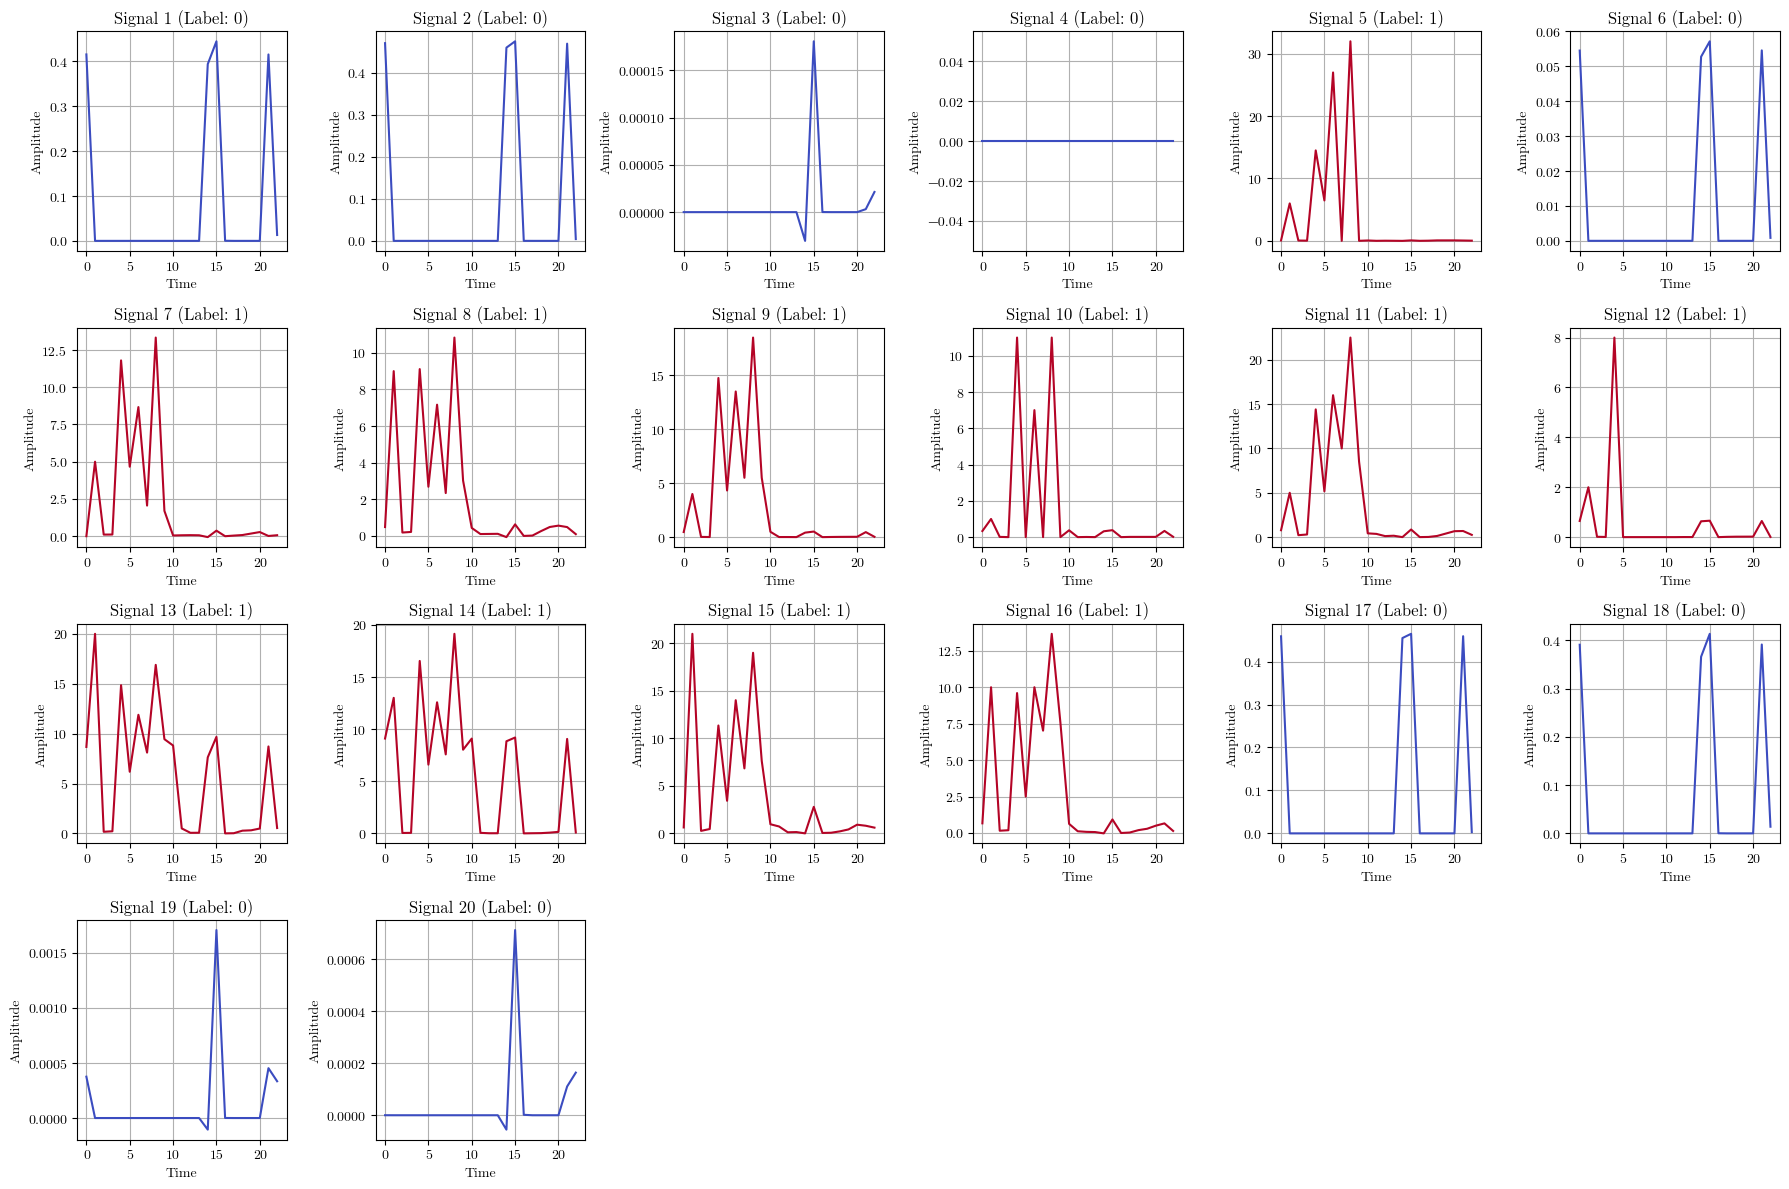

In [ ]:
num_signals, signal_length = random_sample.shape

time_points = np.arange(signal_length)

num_rows = 8
num_cols = 6
fig, axes = plt.subplots(4, 6, figsize=(18, 12))

axes = axes.flatten()
cmap = plt.get_cmap('coolwarm', len(np.unique(testPred)))
for i in range(num_signals):
    label = testPred[i]
    color = cmap(label)
    axes[i].plot(time_points, random_sample[i], label = f'Signal {i+1}', color = color)
    axes[i].set_title(f'Signal {i+1} (Label: {label})')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

for i in range(num_signals, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(random_sample, testPred)

In [ ]:
y_train_resampled.shape

(22,)

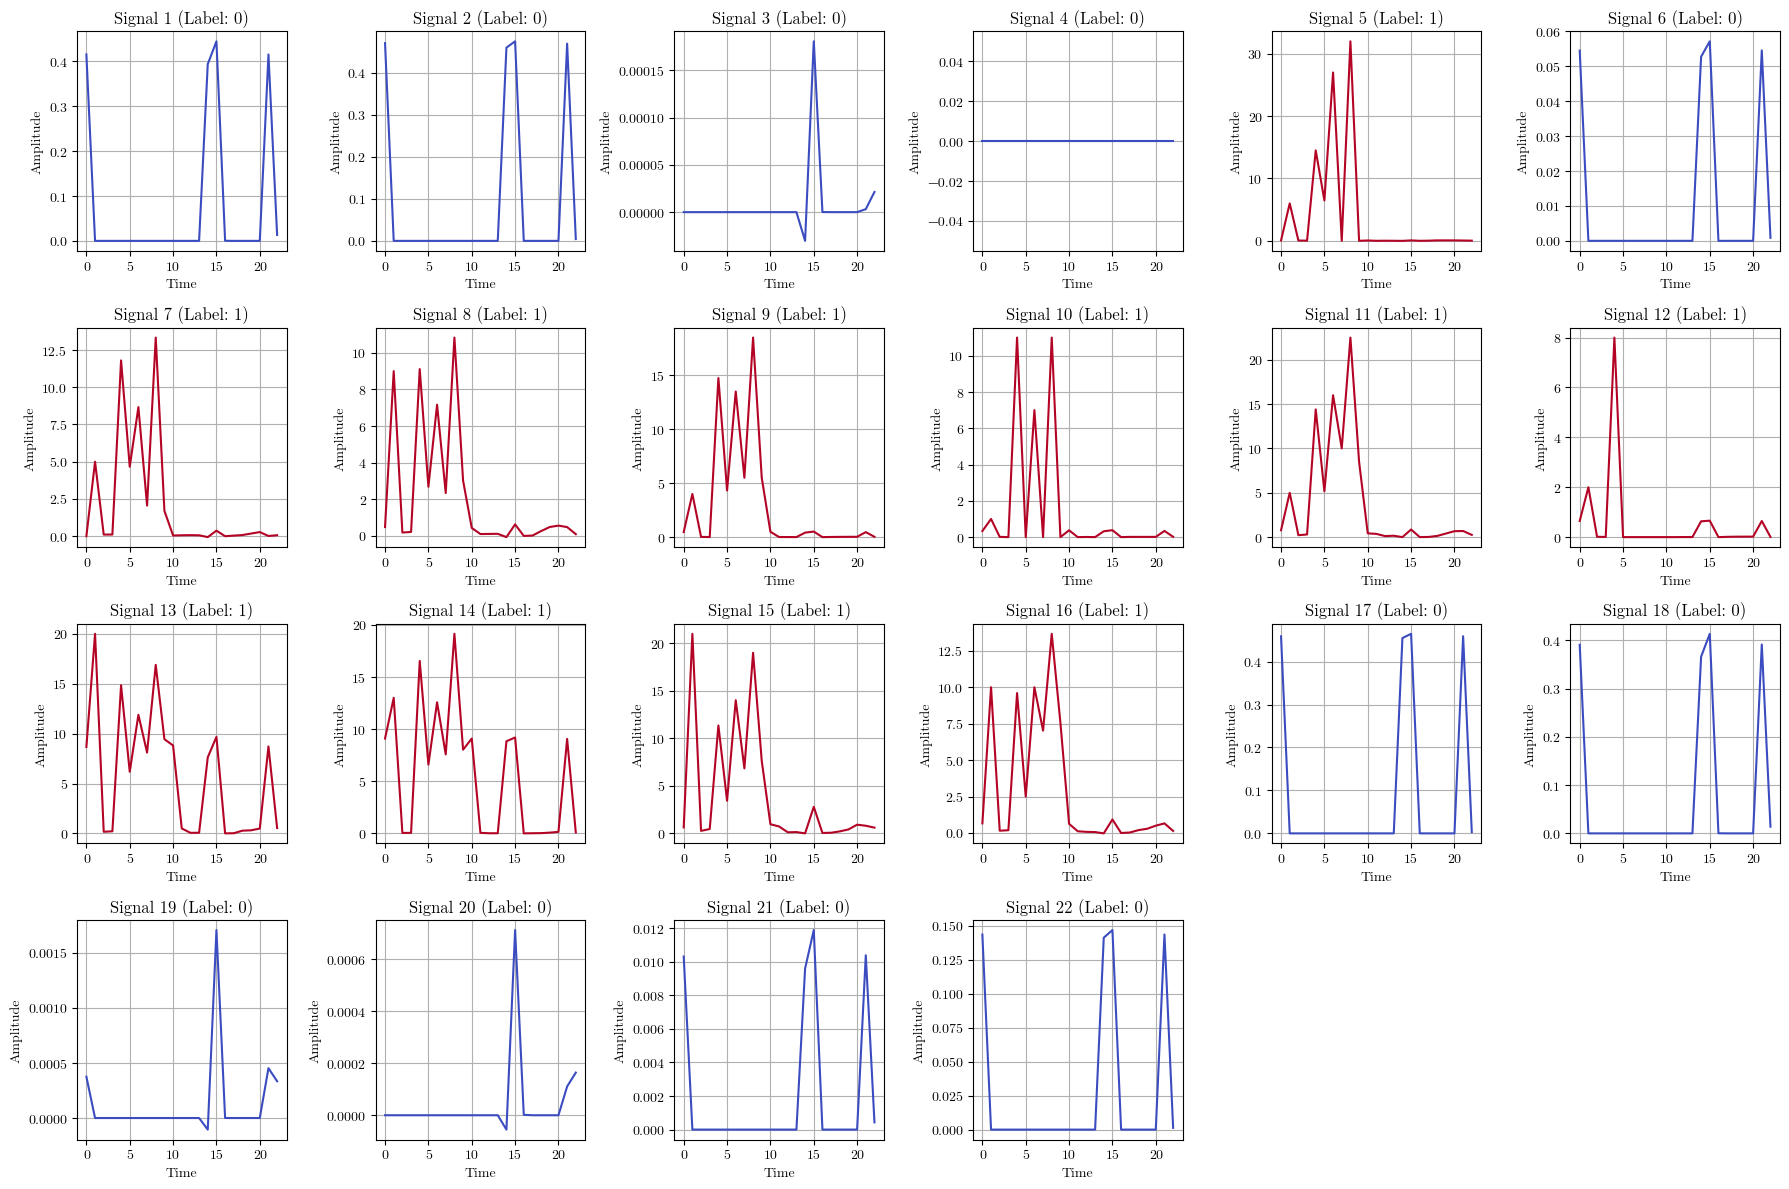

In [ ]:
num_signals, signal_length = X_train_resampled.shape

time_points = np.arange(signal_length)

num_rows = 8
num_cols = 6
fig, axes = plt.subplots(4, 6, figsize=(18, 12))

axes = axes.flatten()
cmap = plt.get_cmap('coolwarm', len(np.unique(y_train_resampled)))
for i in range(num_signals):
    label = y_train_resampled[i]
    color = cmap(label)
    axes[i].plot(time_points, X_train_resampled[i], label = f'Signal {i+1}', color = color)
    axes[i].set_title(f'Signal {i+1} (Label: {label})')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

for i in range(num_signals, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
np.array_equal(random_sample, X_train_resampled)

False

## Synthetic Data Generation (Signal Shifting and Smoothening)

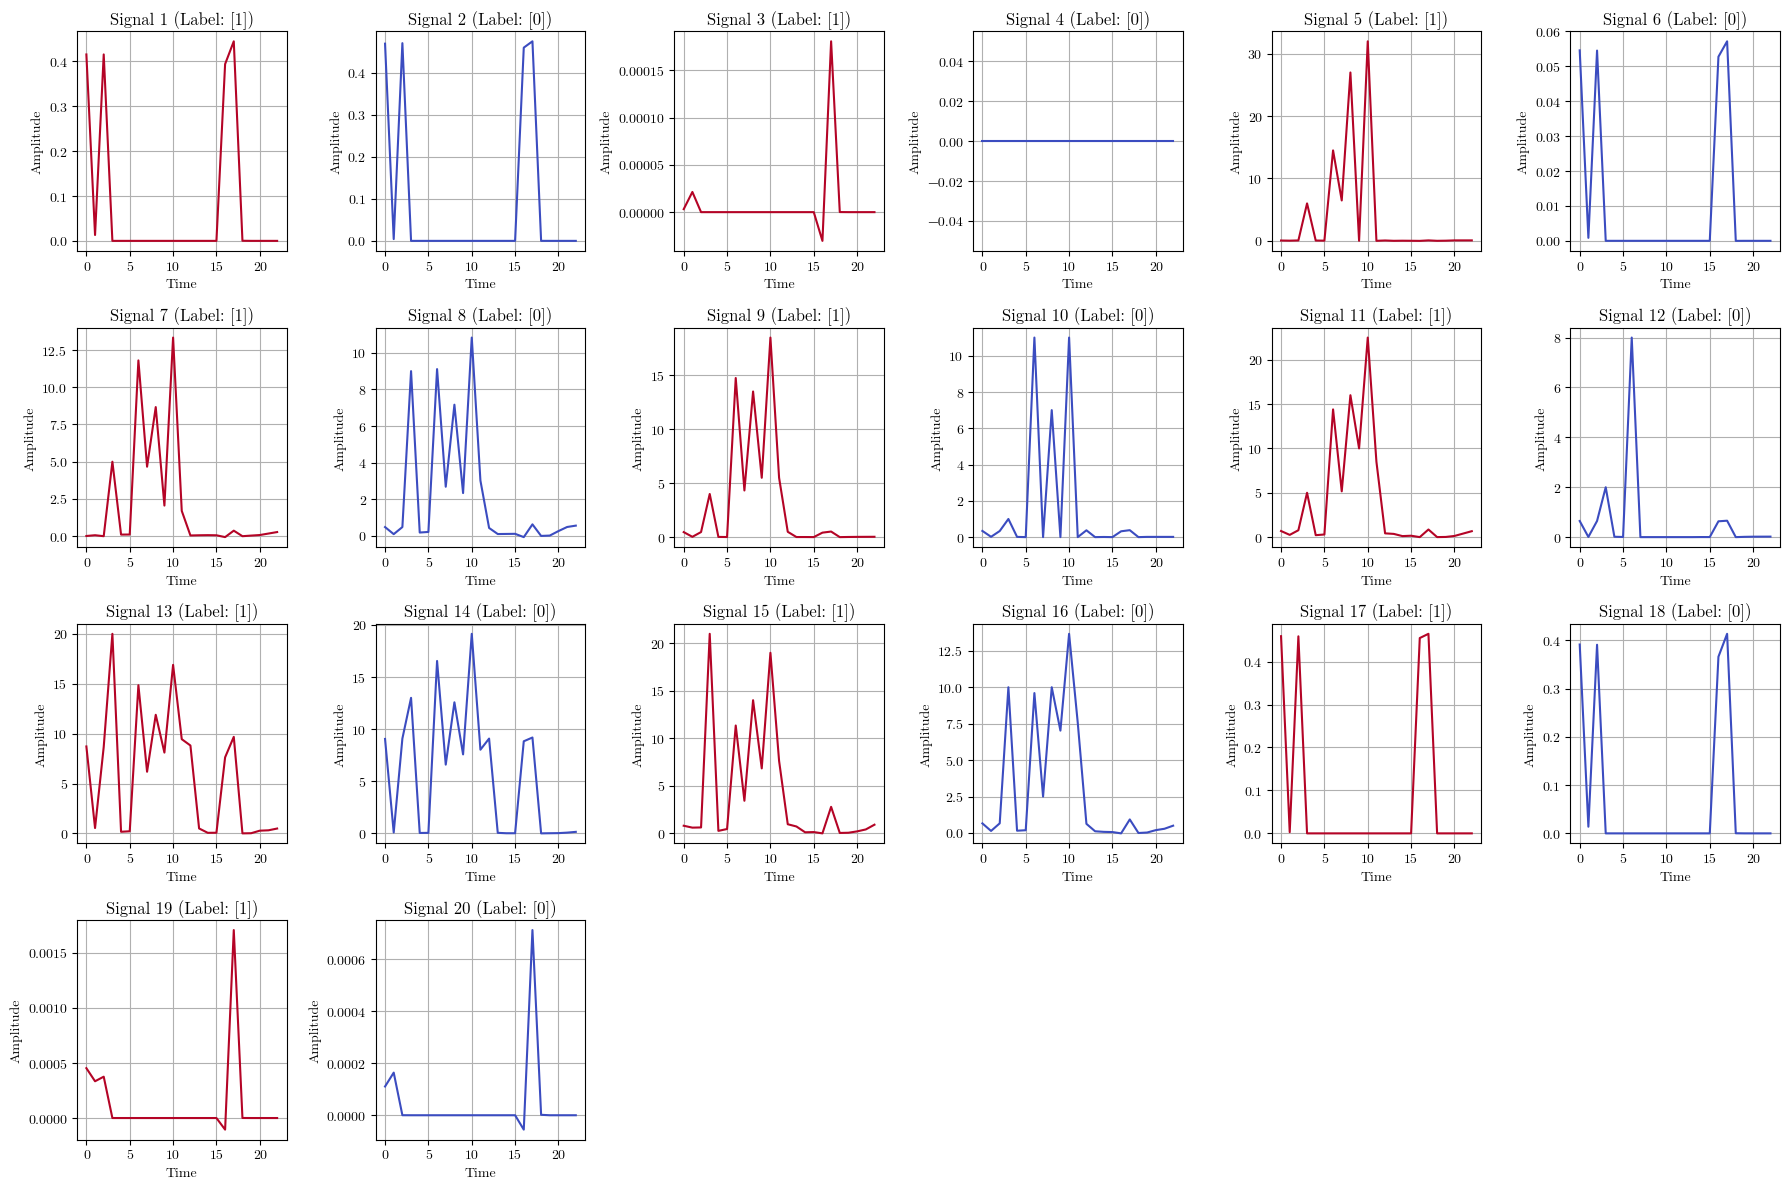

In [ ]:
num_signals, signal_length = X_train.shape

time_points = np.arange(signal_length)

num_rows = 4
num_cols = 6
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))

axes = axes.flatten()
cmap = plt.get_cmap('coolwarm', len(np.unique(y_train)))
for i in range(num_signals):
    label = y_train[i]
    color = cmap(label)
    axes[i].plot(time_points, X_train[i], label = f'Signal {i+1}', color = color)
    axes[i].set_title(f'Signal {i+1} (Label: {label})')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

for i in range(num_signals, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
y_train

array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

## Random Forest Viz

In [ ]:
rfModel.estimators_[5]

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1601326677)

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(rfModel.estimators_[5], out_file='tree_limited.dot',
                rounded = True, proportion = False, precision = 2, filled = True)

In [ ]:
!dot -Tpng tree_limited.dot -o tree_limited.png -Gdpi=600

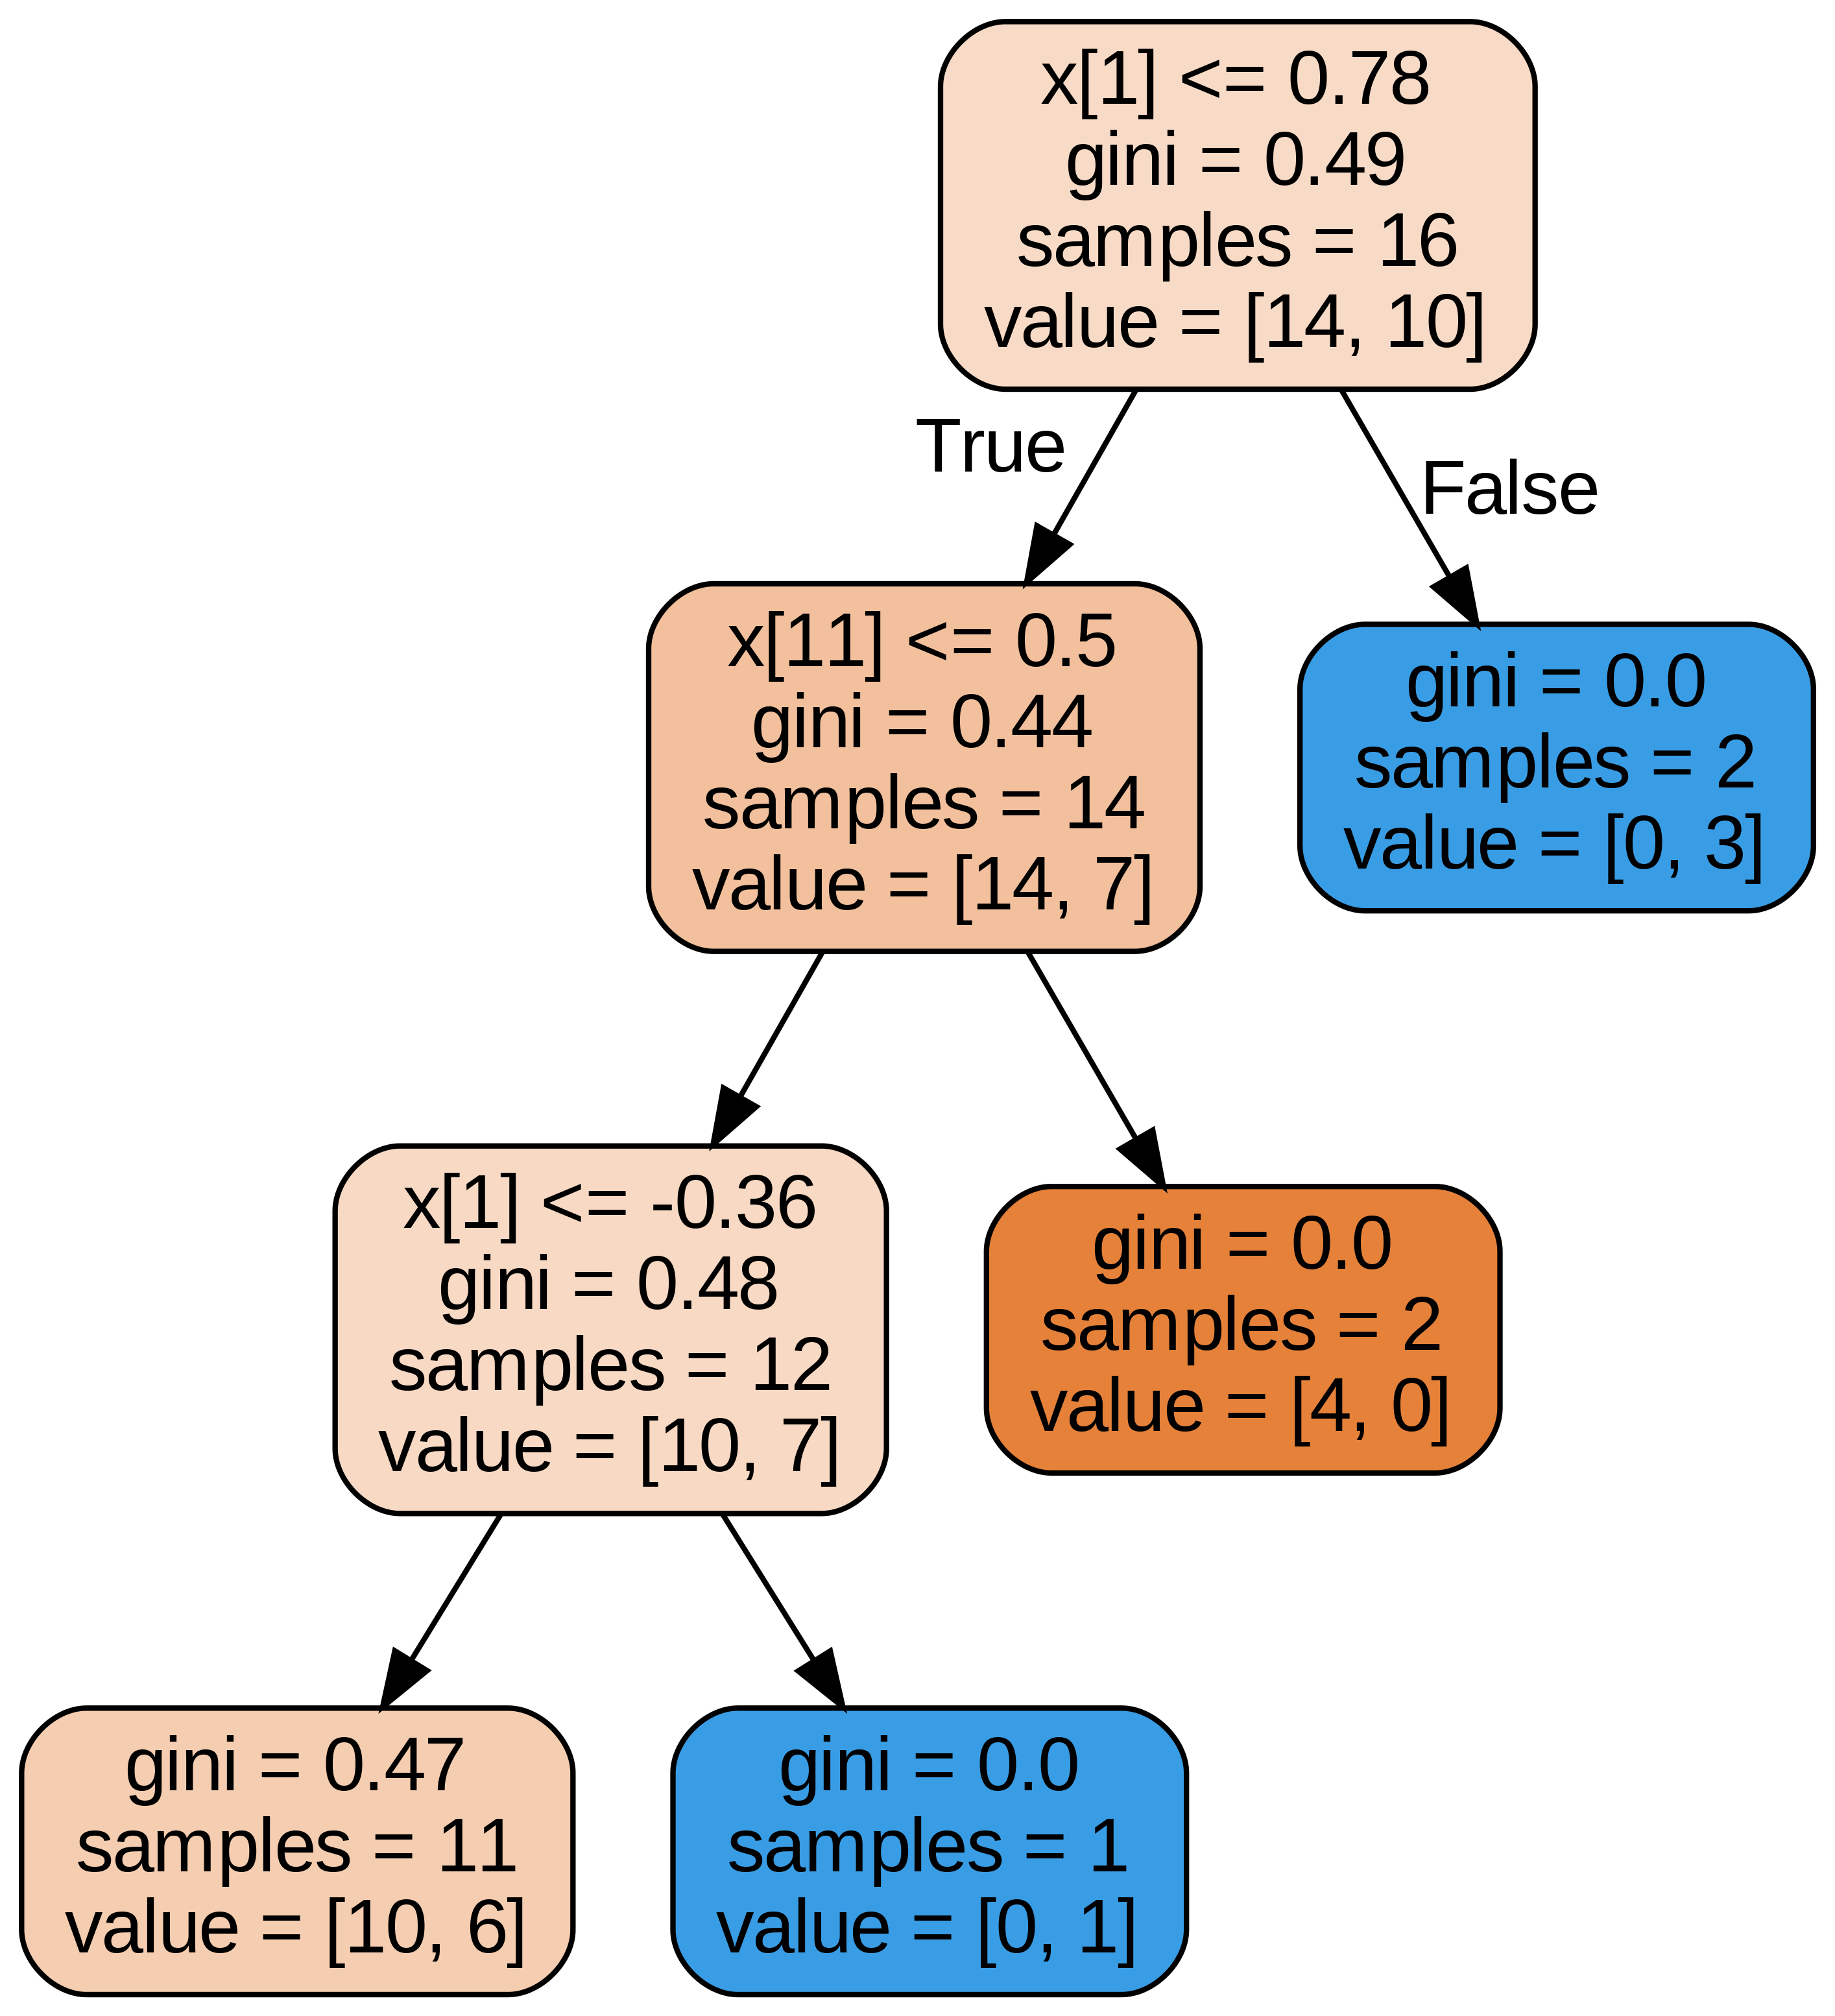

In [ ]:
from IPython.display import Image
Image(filename = 'tree_limited.png')

In [ ]:
y_train.shape

(20, 1)